In [1]:
import json
import time
from typing import Dict

from datasets import load_dataset, load_from_disk# type: ignore
from datasets.formatting.formatting import LazyBatch # type: ignore
from huggingface_hub import list_datasets # type: ignore
import matplotlib.pyplot as plt
from minio import Minio
from minio.datatypes import Object
from minio.helpers import ObjectWriteResult
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style

/Users/nasimeh/anaconda3/envs/npss/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Loading the dataset

In [2]:
data = load_from_disk('Merged_Close_feature_sp_date')
data

DatasetDict({
    train: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 222
    })
    validation: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 22
    })
    test: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 24
    })
})

Transforming to pandas data frame

In [3]:

ds_train = data['train']
ds_test = data['test']
ds_val = data['validation']

df_train = pd.DataFrame(ds_train)
df_test = pd.DataFrame(ds_test)
df_val = pd.DataFrame(ds_val)


    

In [115]:
df_train['Close_numeric']=np.nan
df_test['Close_numeric']=np.nan
df_val['Close_numeric']=np.nan
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           222 non-null    datetime64[ns]
 1   Close          209 non-null    object        
 2   hidden_state   222 non-null    object        
 3   Close_numeric  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ KB


In [5]:
print(df_train['Close'][0])

None


In [118]:
for i in range(0, len(df_train)):
    if df_train['Close'][i] != None:
        df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))

for i in range(0, len(df_test)):
    if df_test['Close'][i] != None:
        df_test['Close_numeric'][i] = float(df_test['Close'][i].replace(',', ''))

for i in range(0, len(df_val)):
    if df_val['Close'][i] != None:
        df_val['Close_numeric'][i] = float(df_val['Close'][i].replace(',', ''))
        
    

/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_36367/2622394368.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))
/var/folders/x3/gbx5bf692bsb2gf_sq9cy

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           222 non-null    datetime64[ns]
 1   Close          209 non-null    object        
 2   hidden_state   222 non-null    object        
 3   Close_numeric  209 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ KB


Treat missing values

In [120]:
df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
df_test['Close_numeric'].interpolate(method='nearest', inplace=True)
df_val['Close_numeric'].interpolate(method='nearest', inplace=True)
# Other methods: 'polynomial', 'spline', 'quadratic'
#df_train['Close'].interpolate(method='polynomial', order=2, inplace=True)  # Polynomial interpolation of order 2


/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_36367/3083625172.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_36367/3083625172.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [131]:
df_train['Close_numeric'][0]=df_train['Close_numeric'][1]
df_test['Close_numeric'][len(df_test)-1]=df_test['Close_numeric'][len(df_test)-2]
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           22 non-null     datetime64[ns]
 1   Close          21 non-null     object        
 2   hidden_state   22 non-null     object        
 3   Close_numeric  22 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 836.0+ bytes


/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_36367/3428700610.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Close_numeric'][0]=df_train['Close_numeric'][1]
/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipyker

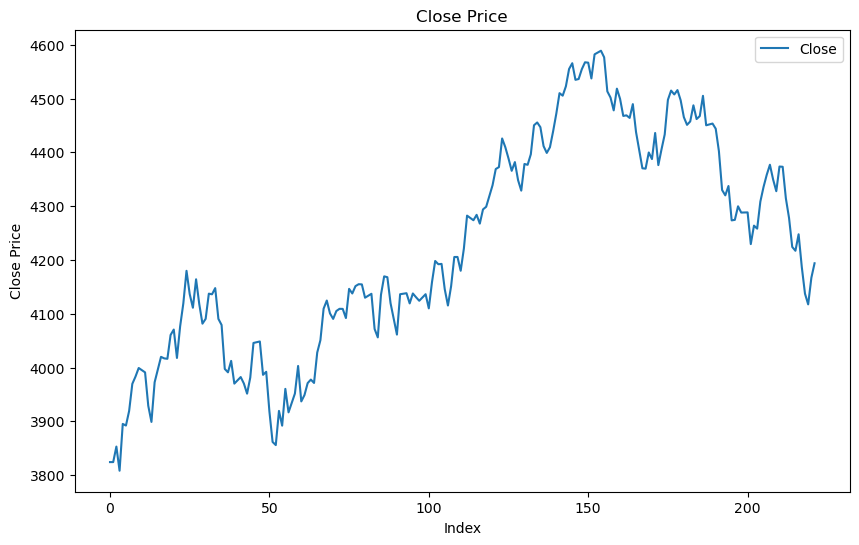

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'], label='Close')

plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()


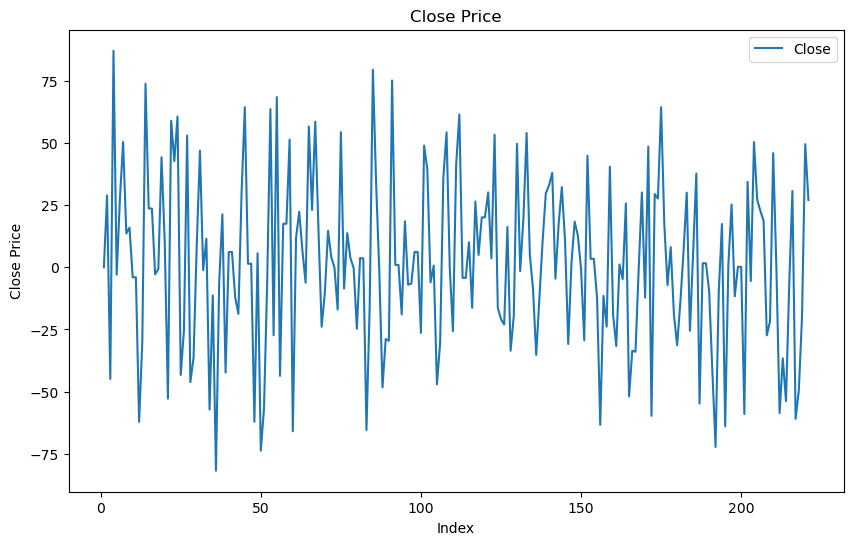

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'].diff(), label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

SARIMA model without exogenous random variable  

In [79]:
import statsmodels.tsa.api as sm

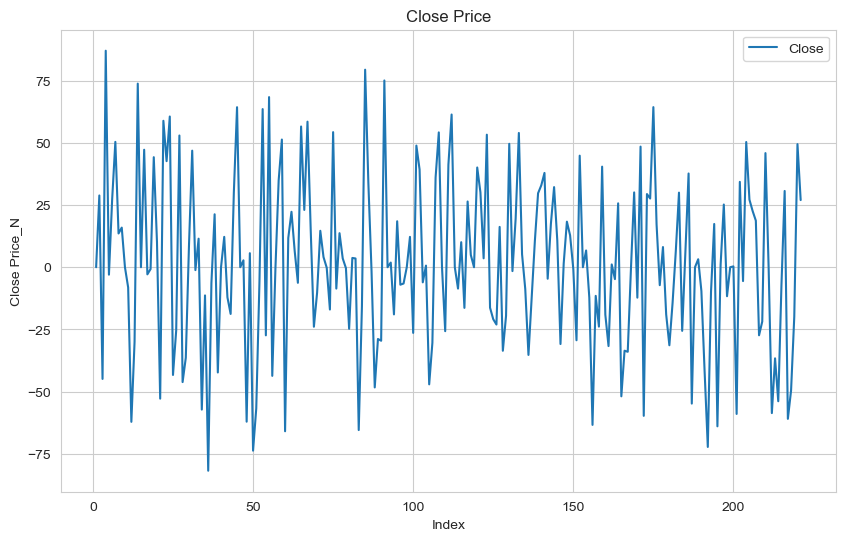

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'].diff(), label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price_N')
plt.legend()
plt.show()

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

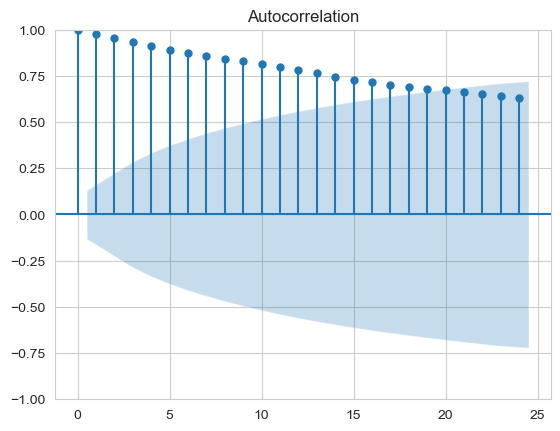

In [83]:
plot_acf(df_train['Close_numeric'].dropna())
plt.show()

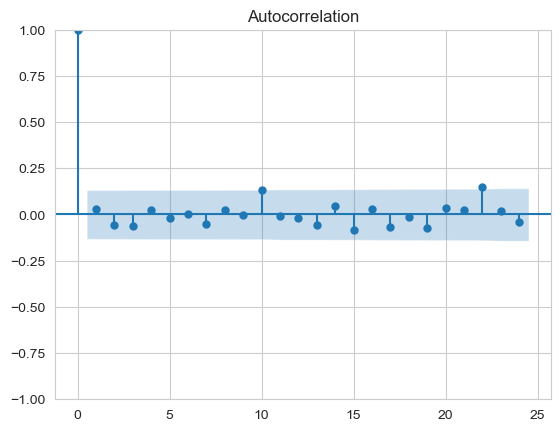

In [82]:
plot_acf(df_train['Close_numeric'].diff().dropna())
plt.show()

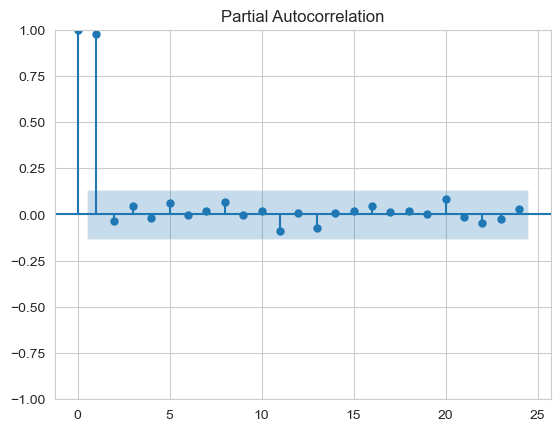

In [86]:
plot_pacf(df_train['Close_numeric'].dropna())
plt.show()

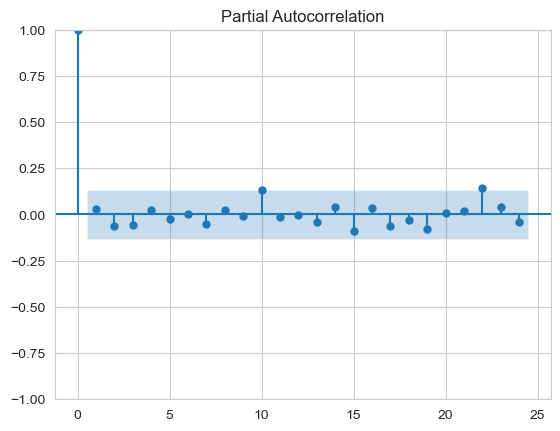

In [87]:
plot_pacf(df_train['Close_numeric'].diff().dropna())
plt.show()

In [89]:
from pmdarima import auto_arima

In [99]:
df_train_diff=df_train['Close_numeric'].diff()
df_train_diff[0]=0
auto_arima(df_train_diff, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2201.125, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2202.936, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2202.911, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2199.653, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2204.779, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.229 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [108]:
auto_arima(df_train['Close_numeric'], trace=True, suppress_warnings=True, seasonal=True, m=5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=2192.223, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=2195.956, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=2195.948, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=2190.752, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=2194.153, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=2194.168, Time=0.01 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=2192.875, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=2194.035, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=2194.011, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=2195.886, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[5]          
Total fit time: 0.757 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
      suppress_warnings=True, with_intercept=False)

In [157]:
# This is how we fit the model
model = sm.ARIMA(df_train['Close_numeric'][1:], order = (4, 2,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Close_numeric   No. Observations:                  221
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -1106.293
Date:                Sun, 26 May 2024   AIC                           2222.586
Time:                        15:31:41   BIC                           2239.532
Sample:                             0   HQIC                          2229.430
                                - 221                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7529      0.079     -9.574      0.000      -0.907      -0.599
ar.L2         -0.6029      0.083     -7.242      0.000      -0.766      -0.440
ar.L3         -0.4408      0.079     -5.591      0.000      -0.595      -0.286
ar.L4         -0.1955      0.064     -3.054      0.002      -0.321      -0.070
sigma2      1423.3152    148.134      9.608      0.000    1132.977    1713.653
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.57   Prob(JB):                         0.52
Heteroskedasticity (H):               0.63   Skew:                             0.15
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

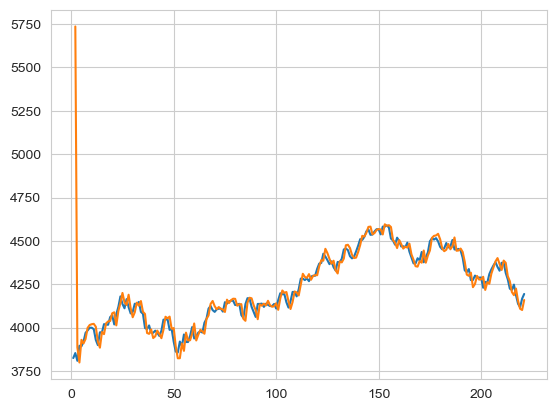

In [158]:
df_train['Close_numeric'][1:].plot()
model.fittedvalues[1:].plot()

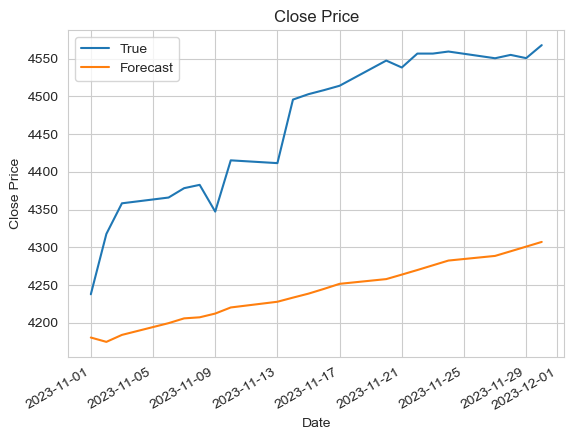

In [161]:
plt.plot(df_val['Date'], df_val['Close_numeric'], label='True')
#plt.plot(df_test['Date'], model.forecast(len(df_test)), label='Forecast')
plt.plot(df_val['Date'], model.forecast(len(df_val)), label='Forecast')
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
